# Google Trends: data exploration

### All Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from IPython.display import display, HTML, Markdown
from word_list.basic import politics1, politics2
from word_list.basic import business
from plot.ts import plot_acf
from plot.lr import simple_lr_plot
from sklearn.model_selection import TimeSeriesSplit

## Create trends df from daily information

In [2]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_df = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends_df.append(ts)

final_date = "2020-07-25"
trends_df = pd.concat(trends_df,1)
trends_df = trends_df[:final_date]
trends_df = trends_df.fillna(0.0)
word_features = list(trends_df.columns)
word_features.sort()
trends_df = trends_df[word_features]
trends_df_train = trends_df[:"2010"]
trends_df_test = trends_df["2010":]
display(Markdown("### Google trends data (training: 2004 -- 2010)"))
display(HTML(trends_df_train.head(5).to_html()))
display(Markdown("#### training data shape = {}".format(trends_df_train.shape))) 

### Google trends data (training: 2004 -- 2010)

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.0,1.0,14.0,25.0,52.0,4.0,1.0,9.0,5.0,46.0,86.0,18.0,77.0,55.0,31.0,10.0,0.0,3.0,63.0,27.0,4.0,49.0,21.0,3.0,0.0,2.0,0.0,14.0,9.0,52.0,20.0,11.0,52.0,3.0,6.0,5.0,5.0,5.0,1.0,10.0,22.0,1.0,1.0,1.0,1.0,4.0,7.0,4.0,0.0,5.0,1.0,13.0,4.0,4.0,33.0,6.0,16.0,13.0,1.0,0.0,70.0,1.0,1.0,11.0,22.0,6.0,0.0,32.0,43.0,11.0,27.0,17.0,2.0,0.0,8.0,25.0,0.0,47.0,1.0,34.0,98.0,85.0,12.0,37.0,28.0,4.0,1.0,1.0,7.0,4.0,6.0,16.0,27.0,6.0,35.0,14.0,0.0,3.0,11.0,4.0,25.0,26.0,9.0,3.0,9.0,27.0,45.0,7.0,1.0,6.0,0.0,3.0,26.0,29.0,2.0,100.0,1.0,0.0,1.0,54.0,58.0,28.0,2.0,1.0,35.0,28.0,26.0,6.0,3.0,6.0,3.0,8.0,26.0,3.0,25.0,3.0,7.0,2.0,4.0,57.0,30.0,4.0,3.0,7.0,7.0,37.0,5.0,6.0,3.0,31.0,7.0,5.0,1.0,1.0,76.0,32.0,18.0,19.0,31.0,8.0,30.0,8.0,3.0,20.0,20.0,66.0,11.0,16.0,23.0,1.0,63.0,7.0,44.0,24.0,0.0,53.0,1.0,1.0,1.0,36.0,60.0,53.0,28.0,0.0,36.0,80.0,80.0
2004-01-02,0.0,2.0,17.0,25.0,90.0,3.0,2.0,5.0,3.0,66.0,76.0,19.0,77.0,49.0,26.0,9.0,1.0,2.0,81.0,25.0,3.0,63.0,18.0,4.0,0.0,2.0,0.0,20.0,11.0,82.0,33.0,11.0,66.0,3.0,8.0,5.0,6.0,5.0,1.0,17.0,32.0,1.0,3.0,1.0,1.0,5.0,4.0,3.0,0.0,3.0,2.0,17.0,4.0,4.0,47.0,11.0,31.0,11.0,5.0,1.0,52.0,1.0,1.0,5.0,15.0,4.0,2.0,29.0,48.0,16.0,29.0,26.0,3.0,1.0,7.0,18.0,1.0,71.0,2.0,28.0,99.0,95.0,14.0,53.0,35.0,10.0,2.0,1.0,10.0,3.0,6.0,15.0,21.0,9.0,52.0,14.0,1.0,2.0,12.0,7.0,36.0,27.0,13.0,3.0,14.0,27.0,41.0,6.0,2.0,4.0,2.0,3.0,24.0,31.0,4.0,95.0,3.0,0.0,2.0,69.0,63.0,26.0,2.0,1.0,33.0,32.0,30.0,10.0,3.0,2.0,3.0,11.0,36.0,3.0,28.0,5.0,5.0,1.0,3.0,44.0,25.0,2.0,8.0,8.0,10.0,30.0,6.0,6.0,10.0,43.0,9.0,5.0,3.0,1.0,93.0,59.0,14.0,24.0,33.0,4.0,35.0,10.0,4.0,26.0,18.0,77.0,10.0,11.0,21.0,1.0,59.0,9.0,54.0,16.0,0.0,61.0,2.0,1.0,1.0,41.0,80.0,55.0,32.0,1.0,36.0,94.0,91.0
2004-01-03,0.0,1.0,16.0,22.0,67.0,5.0,1.0,5.0,6.0,51.0,89.0,21.0,89.0,40.0,27.0,9.0,3.0,3.0,70.0,35.0,3.0,49.0,16.0,3.0,0.0,2.0,0.0,13.0,9.0,69.0,23.0,13.0,60.0,5.0,6.0,2.0,6.0,5.0,1.0,16.0,26.0,2.0,2.0,1.0,0.0,2.0,3.0,5.0,1.0,3.0,1.0,12.0,4.0,3.0,34.0,7.0,14.0,14.0,3.0,1.0,51.0,1.0,1.0,9.0,17.0,8.0,1.0,29.0,41.0,14.0,27.0,19.0,2.0,0.0,6.0,13.0,1.0,53.0,1.0,26.0,93.0,95.0,9.0,44.0,23.0,10.0,1.0,1.0,7.0,3.0,7.0,15.0,26.0,6.0,43.0,13.0,0.0,1.0,13.0,8.0,27.0,32.0,8.0,3.0,11.0,27.0,40.0,8.0,1.0,3.0,2.0,5.0,23.0,28.0,6.0,97.0,2.0,0.0,1.0,62.0,65.0,28.0,2.0,1.0,36.0,27.0,26.0,7.0,2.0,2.0,1.0,10.0,31.0,3.0,27.0,4.0,8.0,2.0,4.0,50.0,26.0,2.0,7.0,9.0,8.0,

#### training data shape = (2557, 187)

## Category Trend

We can aggregate the words in major categories. Here we use the categories **Politics1**, **Politics2** and **Business** (first defined in [Quantifying the semantics of search behavior before stock market moves](https://www.pnas.org/content/111/32/11600))

### Trend over time

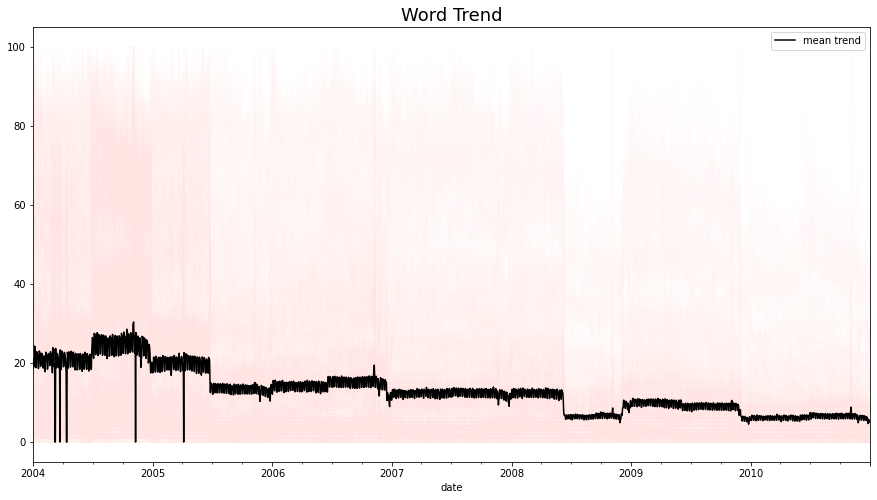

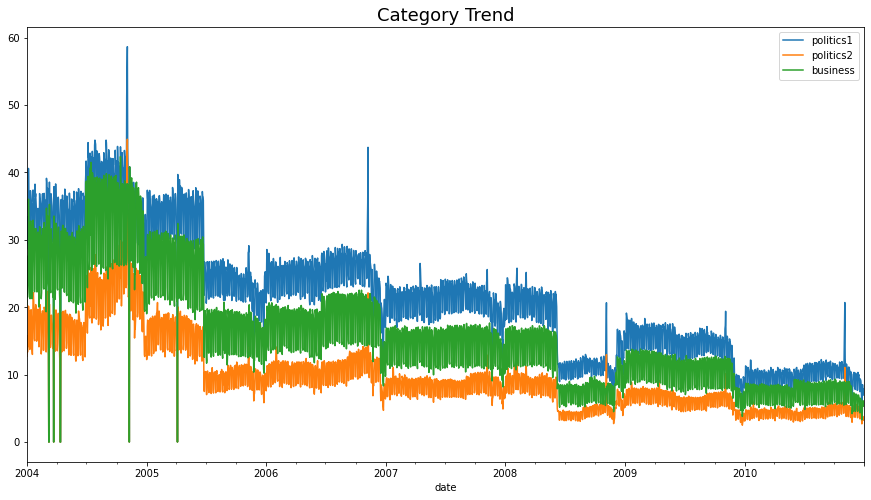

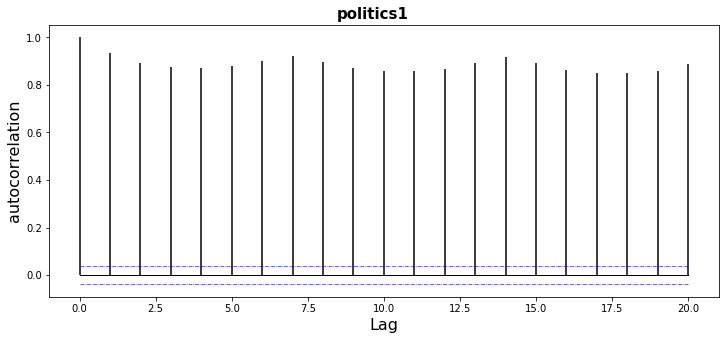

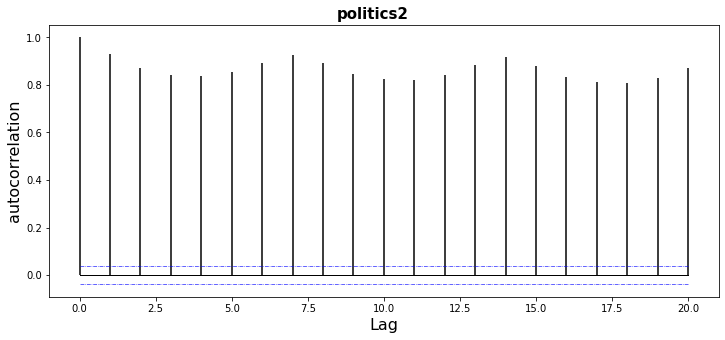

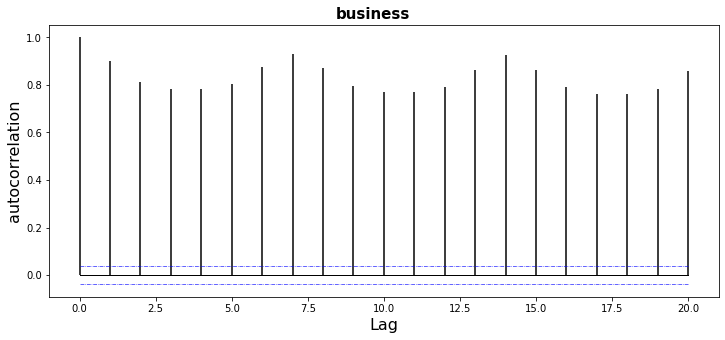

In [3]:
trends_df_p = trends_df_train.copy()
trends_df_p.columns = [""]* trends_df_p.shape[1]

politics1_ts = trends_df_train[politics1].mean(1)
politics1_ts.name = "politics1"
politics2_ts = trends_df_train[politics2].mean(1)
politics2_ts.name = "politics2"
business_ts = trends_df_train[business].mean(1)
business_ts.name = "business"

display(Markdown("### Trend over time"))
fig, ax = plt.subplots(figsize=(15,8))
trends_df_p.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends_df_train.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Trend", fontsize=18);
ax.legend(loc="best");


fig, ax = plt.subplots(figsize=(15,8))
politics1_ts.plot(ax=ax);
politics2_ts.plot(ax=ax);
business_ts.plot(ax=ax);
ax.set_title("Category Trend", fontsize=18);
ax.legend(loc="best");

plot_acf(politics1_ts, lag_range=21, out_path=None)
plot_acf(politics2_ts, lag_range=21, out_path=None)
plot_acf(business_ts, lag_range=21, out_path=None)

## Feature Correlation

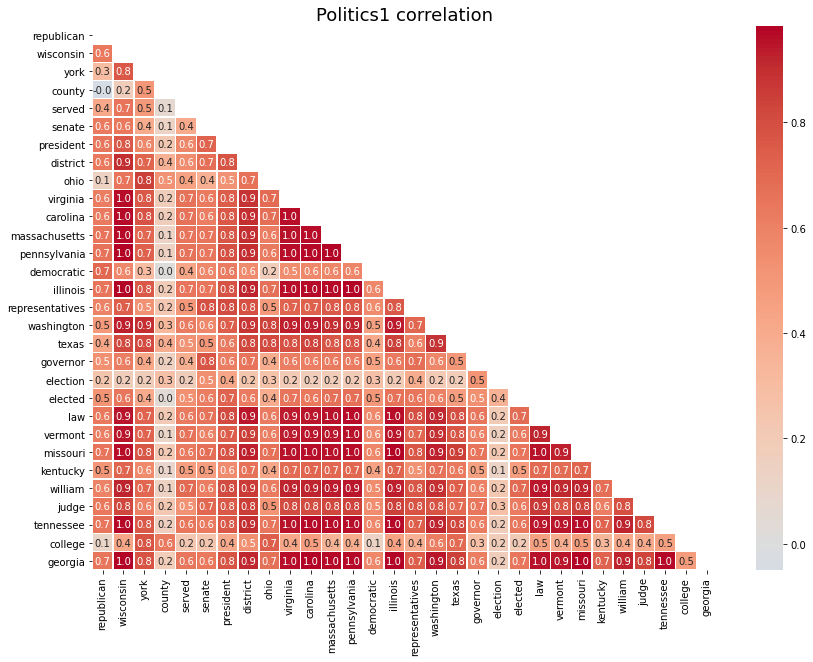

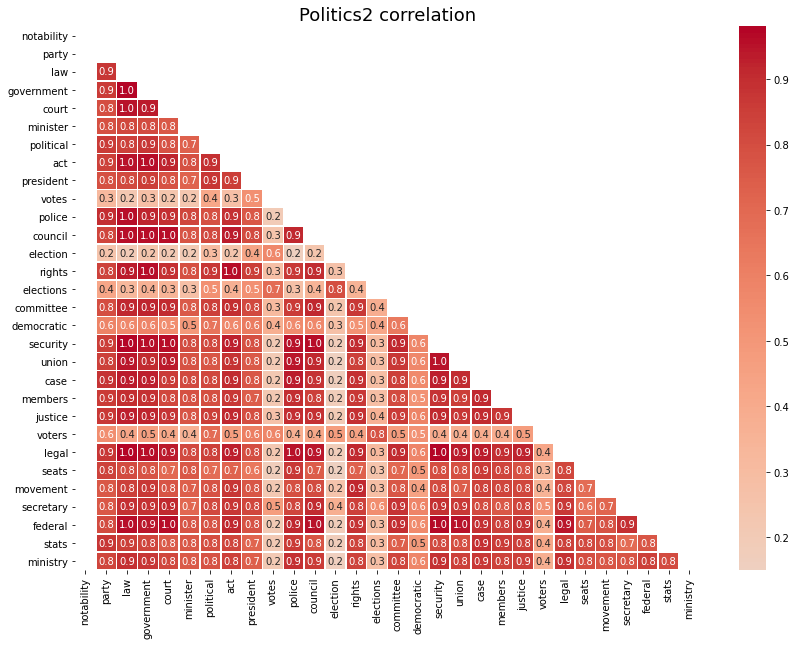

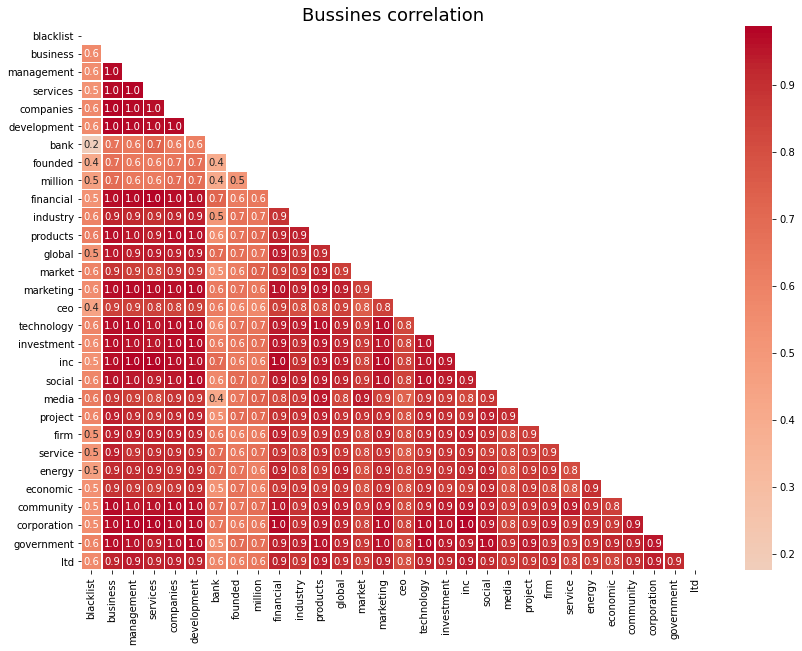

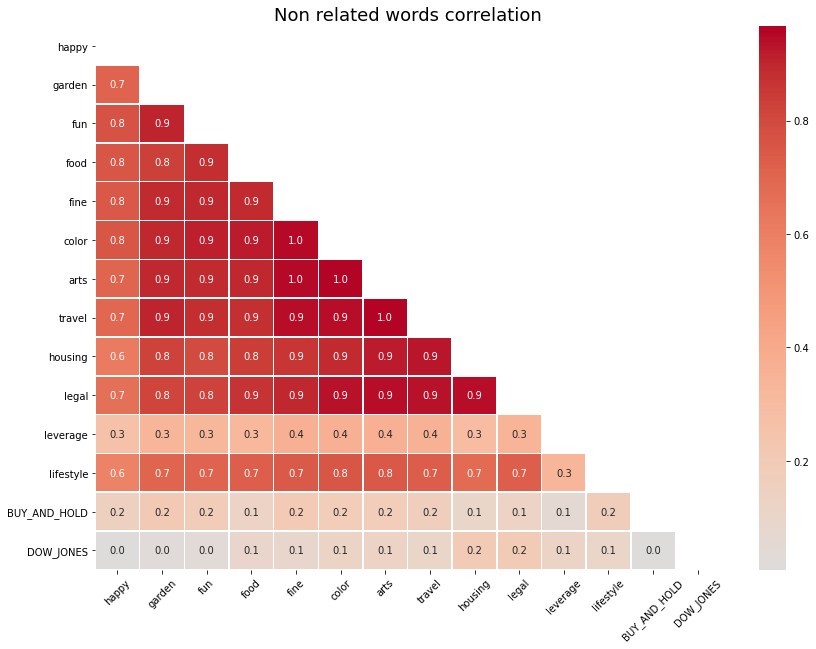

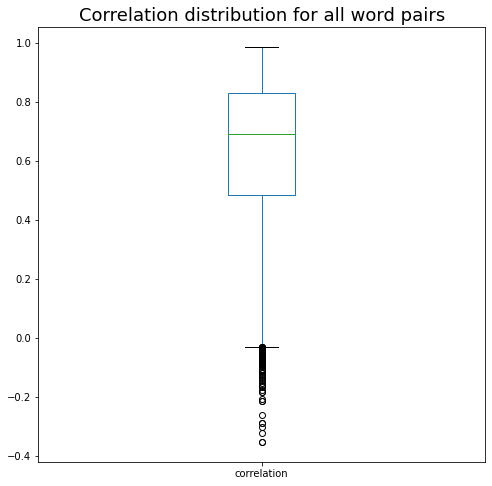

In [4]:
corr = trends_df_train[politics1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics1 correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train[politics2].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics2 correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train[business].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Bussines correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);

non_related_words = ["happy", "garden", "fun",
                     "food", "fine", "color",
                     "arts", "travel", "housing",
                     "legal", "leverage", "lifestyle",
                     "BUY_AND_HOLD", "DOW_JONES"]

corr = trends_df_train[non_related_words].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Non related words correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=45);

corr = trends_df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_df = pd.DataFrame(corr.mask(cond=mask).values.flatten()).dropna()
corr_df.columns = ["correlation"]
fig, ax = plt.subplots(figsize=(8,8))
corr_df.boxplot(ax=ax, grid=False);
ax.set_title(r"Correlation distribution for all word pairs", fontsize=18);

## Data transformation by differencing


For each word $w$, ${X^{w}}_t$ is the associated trend series. The $k$ difference is define as:

\begin{equation}
{D^{w}}_t = {X^{w}}_t - {X^{w}}_{t-k}
\end{equation}

In [5]:
k = 1
trends_df_train_diff  = trends_df_train.diff(k).dropna()

## Looking at correlation of the transformed data

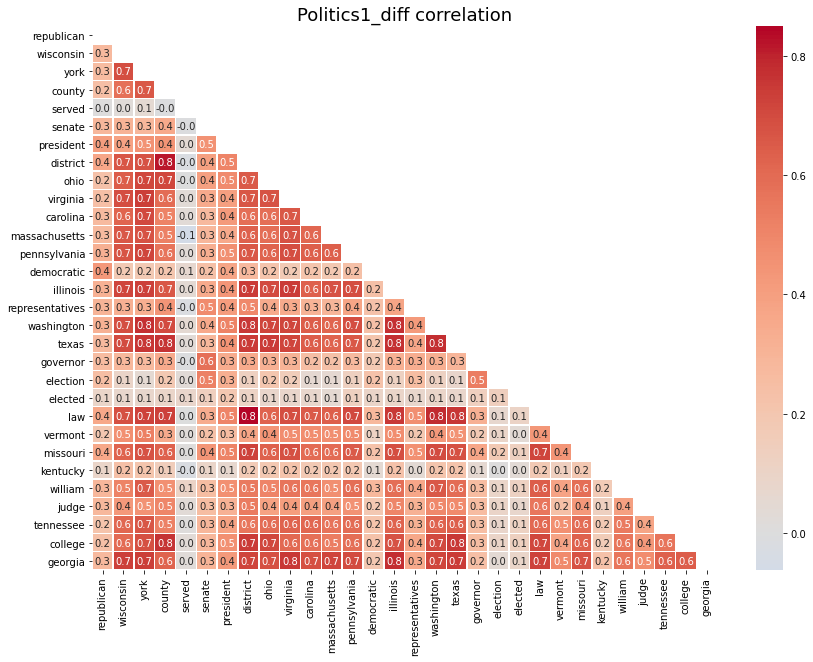

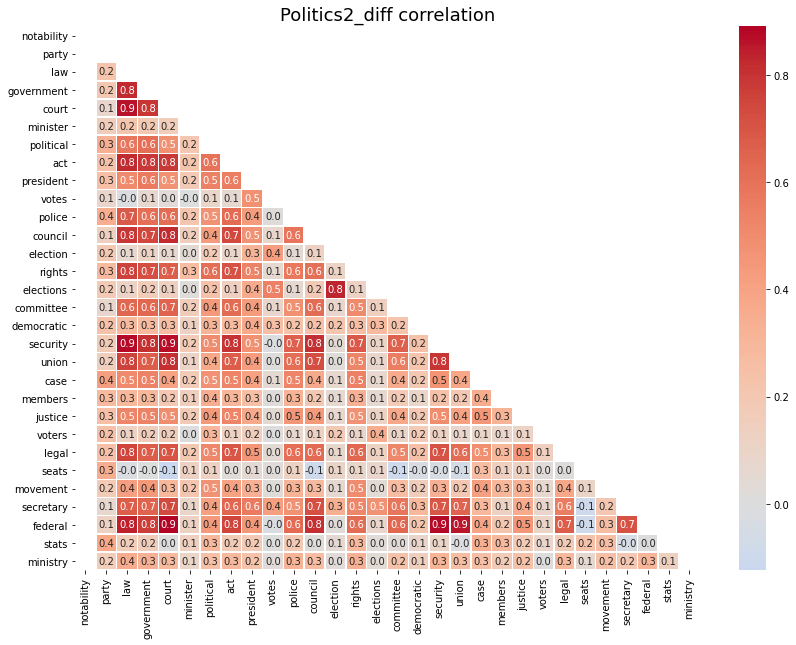

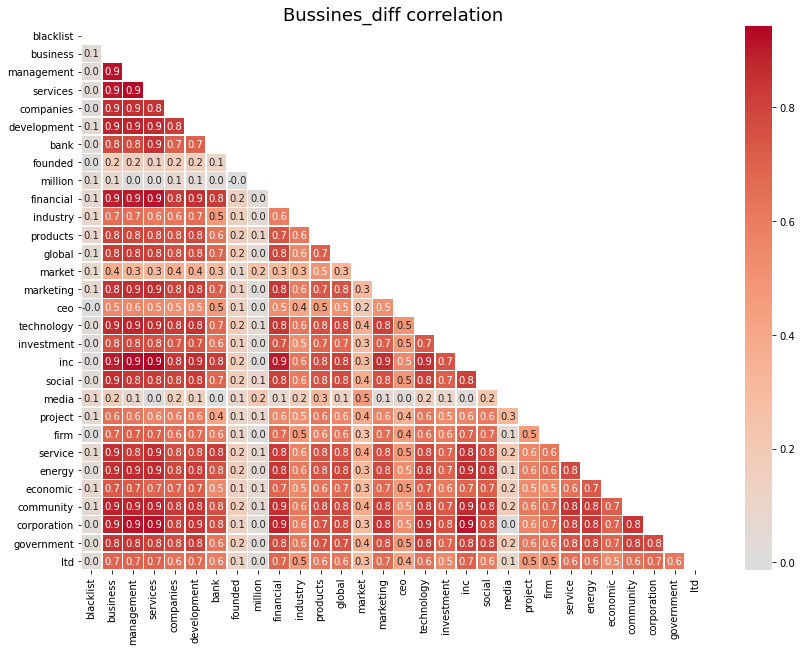

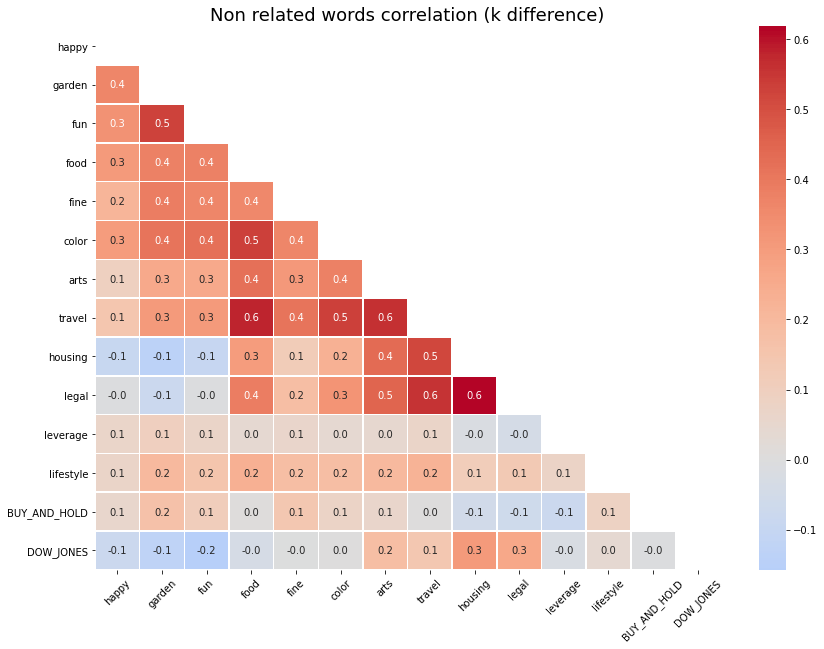

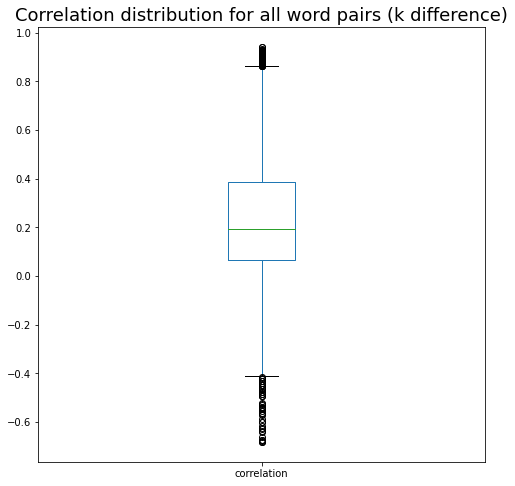

In [6]:
corr = trends_df_train_diff[politics1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics1_diff correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train_diff[politics2].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics2_diff correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train_diff[business].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Bussines_diff correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);

non_related_words = ["happy", "garden", "fun",
                     "food", "fine", "color",
                     "arts", "travel", "housing",
                     "legal", "leverage", "lifestyle",
                     "BUY_AND_HOLD", "DOW_JONES"]

corr = trends_df_train_diff[non_related_words].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Non related words correlation (k difference)", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=45);

corr = trends_df_train_diff.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_df = pd.DataFrame(corr.mask(cond=mask).values.flatten()).dropna()
corr_df.columns = ["correlation"]
fig, ax = plt.subplots(figsize=(8,8))
corr_df.boxplot(ax=ax, grid=False);
ax.set_title(r"Correlation distribution for all word pairs (k difference)", fontsize=18);

## Properties of the transformed trend series

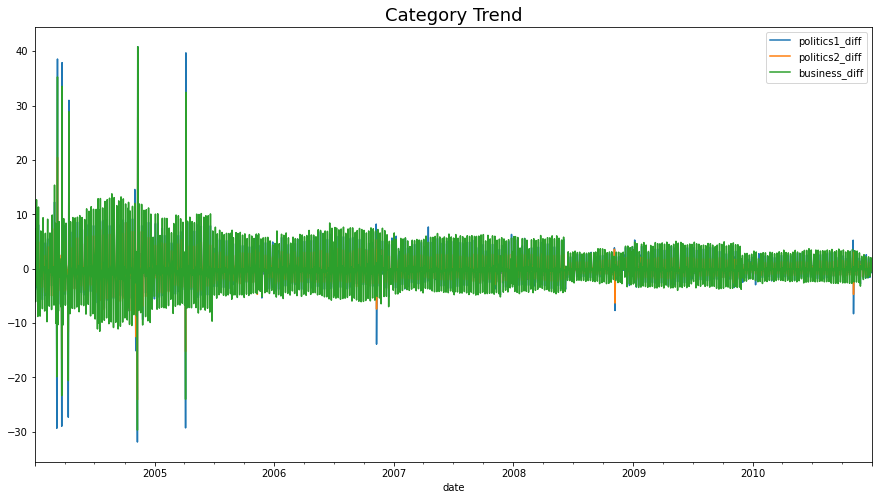

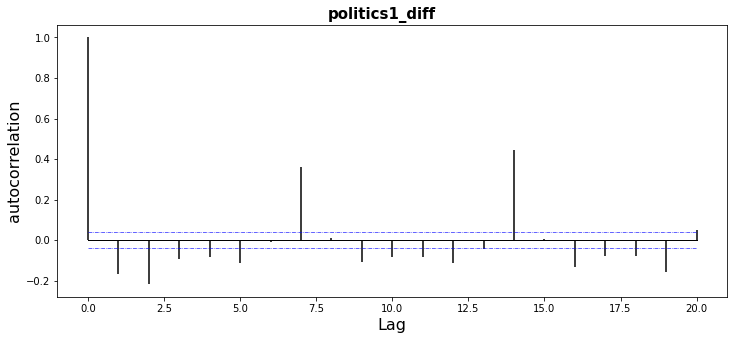

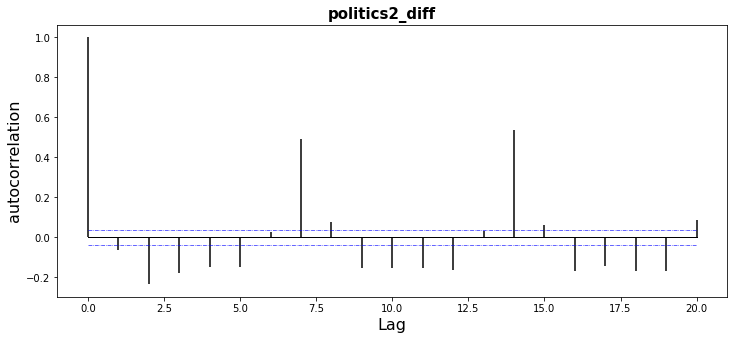

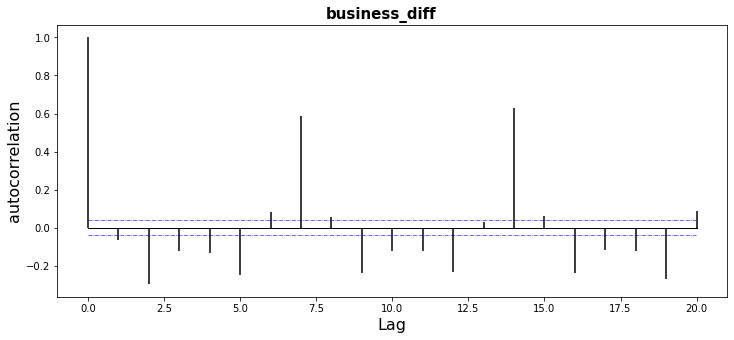

In [7]:
politics1_ts = trends_df_train_diff[politics1].mean(1)
politics1_ts.name = "politics1_diff"
politics2_ts = trends_df_train_diff[politics2].mean(1)
politics2_ts.name = "politics2_diff"
business_ts = trends_df_train_diff[business].mean(1)
business_ts.name = "business_diff"

fig, ax = plt.subplots(figsize=(15,8))
politics1_ts.plot(ax=ax);
politics2_ts.plot(ax=ax);
business_ts.plot(ax=ax);
ax.set_title("Category Trend", fontsize=18);
ax.legend(loc="best");

plot_acf(politics1_ts, lag_range=21, out_path=None)
plot_acf(politics2_ts, lag_range=21, out_path=None)
plot_acf(business_ts, lag_range=21, out_path=None)

## Simple Regression

We use the $k$ trend difference on day t to predict returs on the day t+1 using a simple linear regression. In other words, we assume that:

\begin{equation}
Y_t = \beta_0 + \beta_1 {D^{w}}_{t-1} + \epsilon_t 
\end{equation}

where $Y_t$ is the return of an instrument at day $t$ and $\epsilon_t \thicksim N(0, \sigma^2)$.

In [8]:
# loading market data and defining return variable
asset = "es1"
market_path = os.path.join('data','market',"{}.txt".format(asset))
df_market = pd.read_csv(market_path, sep='\t')
close_price_column = 'PX_LAST'
date_column='date'
df_market.loc[:, date_column] = pd.to_datetime(df_market[date_column])
df_market = df_market.set_index(date_column)
close = df_market[[close_price_column]].dropna()
close = close.pct_change().dropna()
return_column = "{}_returns".format(asset)
close.columns = [return_column]
close.head(5)

# Merging trend diff data and market data
# We shift return information in one day
merged_df = pd.merge_asof(trends_df_train_diff, close, left_index=True, right_index=True)
merged_df.loc[:, "es1_returns"] = merged_df.es1_returns.shift(-1)
merged_df = merged_df.dropna()

# Defining category features
merged_df.loc[:, "politics1_diff"] = merged_df[politics1].mean(1)
merged_df.loc[:, "politics2_diff"] = merged_df[politics2].mean(1)
merged_df.loc[:, "business_diff"] = merged_df[business].mean(1)
columns = [return_column, "politics1_diff", "politics2_diff", "business_diff"] + word_features
merged_df = merged_df[columns]


display(Markdown("### Merged data (training: 2004 -- 2010)"))
display(HTML(merged_df.head(5).to_html()))
display(Markdown("#### data shape = {}".format(merged_df.shape)))

### Merged data (training: 2004 -- 2010)

,es1_returns,politics1_diff,politics2_diff,business_diff,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,-0.001348,4.700000,3.033333,7.300000,0.0,1.0,3.0,0.0,38.0,-1.0,1.0,-4.0,-2.0,20.0,-10.0,1.0,0.0,-6.0,-5.0,-1.0,1.0,-1.0,18.0,-2.0,-1.0,14.0,-3.0,1.0,0.0,0.0,0.0,6.0,2.0,30.0,13.0,0.0,14.0,0.0,2.0,0.0,1.0,0.0,0.0,7.0,10.0,0.0,2.0,0.0,0.0,1.0,-3.0,-1.0,0.0,-2.0,1.0,4.0,0.0,0.0,14.0,5.0,15.0,-2.0,4.0,1.0,-18.0,0.0,0.0,-6.0,-7.0,-2.0,2.0,-3.0,5.0,5.0,2.0,9.0,1.0,1.0,-1.0,-7.0,1.0,24.0,1.0,-6.0,1.0,10.0,2.0,16.0,7.0,6.0,1.0,0.0,3.0,-1.0,0.0,-1.0,-6.0,3.0,17.0,0.0,1.0,-1.0,1.0,3.0,11.0,1.0,4.0,0.0,5.0,0.0,-4.0,-1.0,1.0,-2.0,2.0,0.0,-2.0,2.0,2.0,-5.0,2.0,0.0,1.0,15.0,5.0,-2.0,0.0,0.0,-2.0,4.0,4.0,4.0,0.0,-4.0,0.0,3.0,10.0,0.0,3.0,2.0,-2.0,-1.0,-1.0,-13.0,-5.0,-2.0,5.0,1.0,3.0,-7.0,1.0,0.0,7.0,12.0,2.0,0.0,2.0,0.0,17.0,27.0,-4.0,5.0,2.0,-4.0,5.0,2.0,1.0,6.0,-2.0,11.0,-1.0,-5.0,-2.0,0.0,-4.0,2.0,10.0,-8.0,0.0,8.0,1.0,0.0,0.0,5.0,20.0,2.0,4.0,1.0,0.0,14.0,11.0
2004-01-03,-0.001348,-3.866667,-2.433333,-6.100000,0.0,-1.0,-1.0,-3.0,-23.0,2.0,-1.0,0.0,3.0,-15.0,13.0,2.0,12.0,-9.0,1.0,0.0,2.0,1.0,-11.0,10.0,0.0,-14.0,-2.0,-1.0,0.0,0.0,0.0,-7.0,-2.0,-13.0,-10.0,2.0,-6.0,2.0,-2.0,-3.0,0.0,0.0,0.0,-1.0,-6.0,1.0,-1.0,0.0,-1.0,-3.0,-1.0,2.0,1.0,0.0,-1.0,-5.0,0.0,-1.0,-13.0,-4.0,-17.0,3.0,-2.0,0.0,-1.0,0.0,0.0,4.0,2.0,4.0,-1.0,0.0,-7.0,-2.0,-2.0,-7.0,-1.0,-1.0,-1.0,-5.0,0.0,-18.0,-1.0,-2.0,-6.0,0.0,-5.0,-9.0,-12.0,0.0,-1.0,0.0,-3.0,0.0,1.0,0.0,5.0,-3.0,-9.0,-1.0,-1.0,-1.0,1.0,1.0,-9.0,5.0,-5.0,0.0,-3.0,0.0,-1.0,2.0,-1.0,-1.0,0.0,2.0,-1.0,-3.0,2.0,2.0,-1.0,0.0,-1.0,-7.0,2.0,2.0,0.0,0.0,3.0,-5.0,-4.0,-3.0,-1.0,0.0,-2.0,-1.0,-5.0,0.0,-1.0,-1.0,3.0,1.0,1.0,6.0,1.0,0.0,-1.0,1.0,-2.0,6.0,-1.0,-1.0,-5.0,-15.0,1.0,0.0,-1.0,0.0,-23.0,-26.0,5.0,-2.0,-3.0,2.0,-8.0,-2.0,-2.0,-4.0,-1.0,-10.0,-1.0,-1.0,5.0,1.0,-5.0,-3.0,-11.0,-2.0,0.0,-6.0,-1.0,0.0,0.0,10.0,-8.0,-8.0,-3.0,-1.0,-2.0,-13.0,-16.0
2004-01-04,0.009919,0.966667,0.700000,0.700000,1.0,0.0,2.0,4.0,-10.0,0.0,-1.0,1.0,0.0,0.0,-8.0,-4.0,-5.0,11.0,-1.0,1.0,-2.0,0.0,-2.0,-8.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,-2.0,4.0,-3.0,-7.0,-2.0,1.0,3.0,1.0,3.0,1.0,3.0,5.0,0.0,-1.0,0.0,0.0,3.0,0.0,-1.0,0.0,1.0,0.0,6.0,0.0,0.0,-5.0,-2.0,3.0,-1.0,1.0,-1.0,10.0,0.0,0.0,-1.0,1.0,-4.0,1.0,-6.0,5.0,-2.0,3.0,2.0,0.0,1.0,2.0,-1.0,0.0,2.0,0.0,-5.0,7.0,-9.0,2.0,-1.0,5.0,-1.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,7.0,3.0,-2.0,1.0,1.0,1.0,-3.0,-1.0,-7.0,1.0,0.

#### data shape = (2555, 191)

## Plotting the results of each simple linear regression model in the IS data

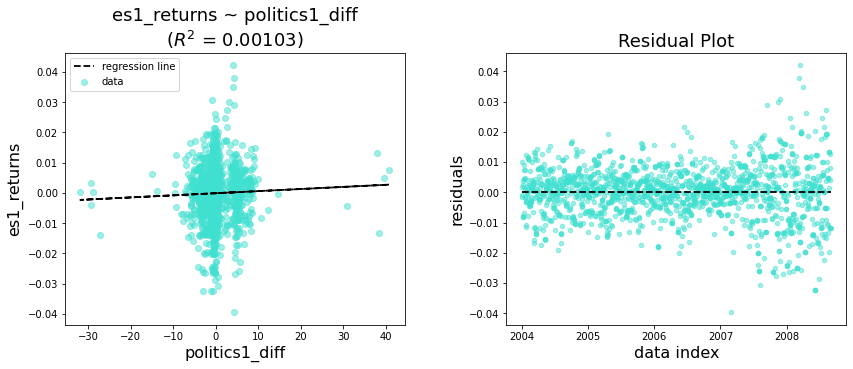

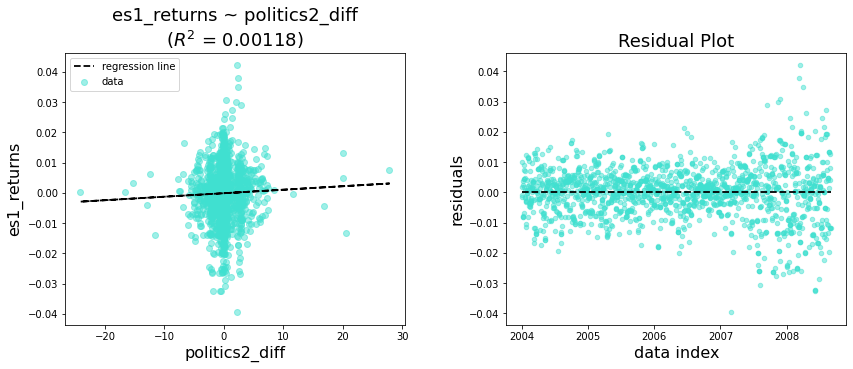

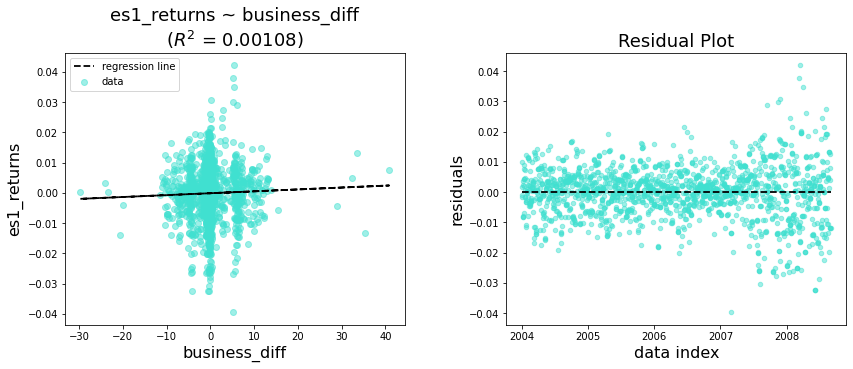

In [9]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(merged_df):
    df_train = merged_df.iloc[train_index]
    df_test = merged_df.iloc[test_index]


simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="politics1_diff")

simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="politics2_diff")

simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="business_diff")